# Introudction to TensorFlow 2.0

## Example: Simple Linear Regression

In this notebook we briefly show how to solve a simple linear regression using [TensorFlow](https://www.tensorflow.org/). This seems like killing a fly with a cannon, but the objective is to ilustrate the overall logic and the syntax similarity to [Numpy](https://www.numpy.org/).

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

## Generate Sample Data

In [2]:
# Set number of samples.
n = 1000
# Generate sample data.
z = tf.random.normal(mean=0, stddev=1, shape=(n, 1))
# Generate a tensor of ones (to model the intercept).
ones = tf.ones(shape=(n, 1))
# Concatenate the tensors. 
Z = tf.concat([ones, z], axis=1)

Let us set the "true" parameters:

In [3]:
beta = tf.constant(
    [[1.0], # Bias (intercept)
     [3.0]] # Weight (slope)
)

Next, we add some random noise and define the target variable as

$$
y = \beta_0 + \beta_1 z + \varepsilon, \quad \varepsilon \sim N(0, \sigma).
$$

In [4]:
sigma = 1
# Add noise.
epsilon = tf.random.normal(mean=0, stddev=sigma, shape=(n, 1))
# Define target variable. 
y = tf.linalg.matmul(Z, beta) + epsilon 

Let us visualize the sample data:

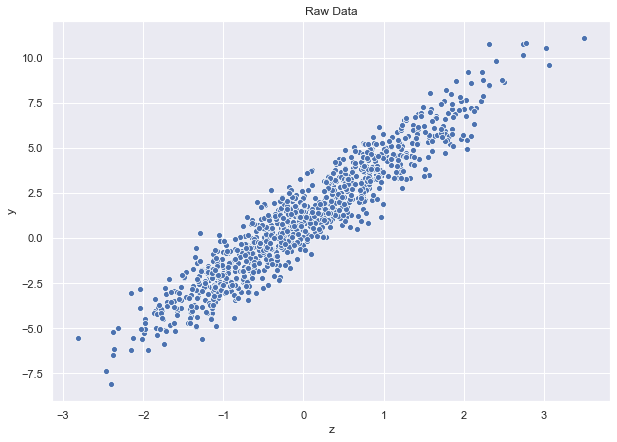

In [5]:
plt.rcParams['figure.figsize'] = (10,7)

fig, ax = plt.subplots()

sns.scatterplot(
    x=Z[:, 1].numpy().flatten(), 
    y=y.numpy().flatten(), 
    ax=ax
)

ax.set(title='Raw Data', xlabel='z', ylabel='y');

## Data Split

Let us do a train-test split of the data:

In [6]:
# Set split poportion.
alpha = 0.75
# Define partition sizes. 
train_size = int(alpha * n)
test_size = n - train_size

In [7]:
# Remove the colum of ones.
X = Z[:, 1]
X = tf.reshape(X, shape=(-1, 1))

In [8]:
# Split data.
X_train, X_test = tf.split(value=X, num_or_size_splits=(train_size, test_size))
y_train, y_test = tf.split(value=y, num_or_size_splits=(train_size, test_size))

Let us plot these two set of points:

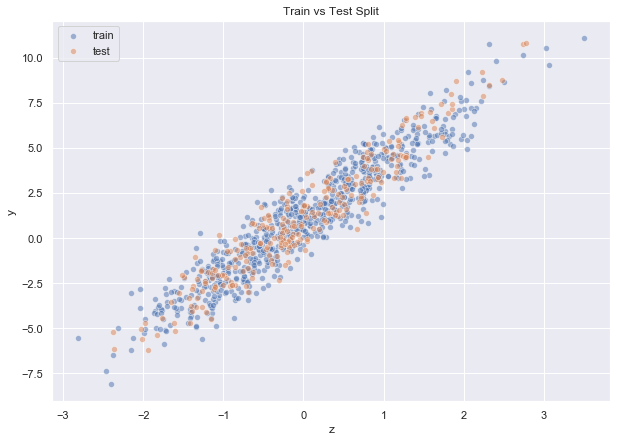

In [9]:
fig, ax = plt.subplots()

sns.scatterplot(
    x=X_train.numpy().flatten(), 
    y=y_train.numpy().flatten(), 
    alpha=0.5,
    ax=ax, 
    label='train'
)

sns.scatterplot(
    x=X_test.numpy().flatten(), 
    y=y_test.numpy().flatten(), 
    ax=ax, 
    alpha=0.5,
    label='test'
)

ax.set(title='Train vs Test Split', xlabel='z', ylabel='y')
ax.legend();

## Define Model

We now define a very simple neural network: one layer and no activation function(i.e. a simple linear regression):

In [10]:
def build_model():
    # Define layer structure. 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=[X_train.shape[1]])
    ])
    # Set optimizer (in this case Stochastic Gradient Descent). 
    optimizer = tf.keras.optimizers.SGD(lr=0.001)
    # Compile model by defining loss function and tracking metrics. 
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

In [11]:
model = build_model()

In [12]:
# Printo model specification.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Let us plot the prediction with the initialization values of the weight parameters:

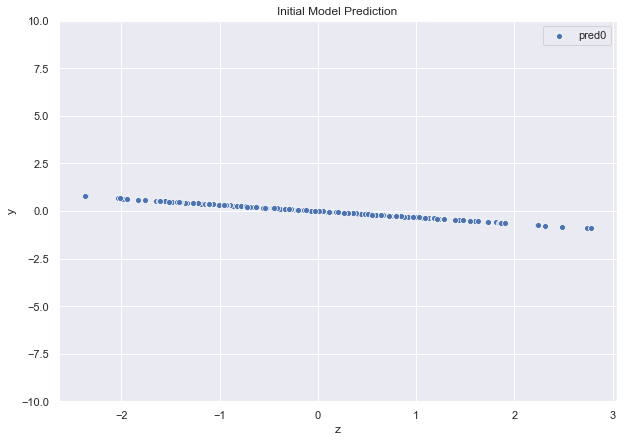

In [13]:
fig, ax = plt.subplots()

# Get prediction.
y_pred0 = model.predict(X_test)

sns.scatterplot(
    x=X_test.numpy().flatten(), 
    y=y_pred0.flatten(), 
    ax=ax, 
    label='pred0'
)

ax.set(
    title='Initial Model Prediction', 
    ylim=(-10, 10), 
    xlabel='z', 
    ylabel='y')
ax.legend();

## Train Model

In [14]:
# We train the model and save the history. 
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=256,
    epochs=1000, 
    validation_split=0.2,
    verbose=0
)

In [15]:
# Store history in a data frame. 
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = history.epoch

hist_df.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,13.203400,2.979318,13.203400,16.453764,3.199265,16.453764,0
1,13.050981,2.961680,13.050982,16.282001,3.182879,16.282001,1
2,12.909640,2.945441,12.909640,16.097496,3.165154,16.097496,2
3,12.760080,2.927951,12.760079,15.917605,3.147773,15.917605,3
4,12.615474,2.910942,12.615474,15.751198,3.131605,15.751198,4


## Model Evaluation

Let us plot the lost function on the train and test set:

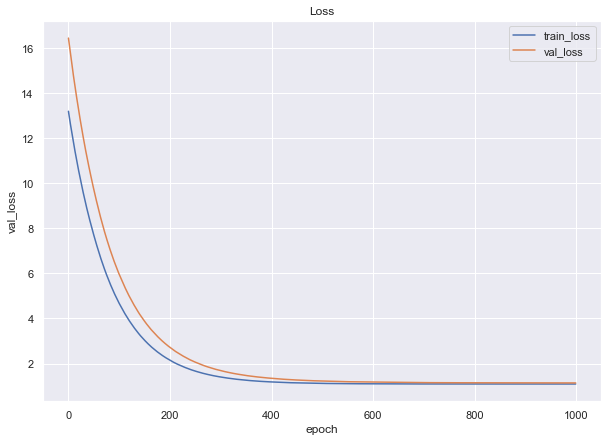

In [16]:
fig, ax = plt.subplots()

sns.lineplot(x='epoch', y='loss', data=hist_df, ax=ax, label='train_loss')
sns.lineplot(x='epoch', y='val_loss', data=hist_df, ax=ax, label='val_loss')

ax.set(title='Loss');

We see how the global minima was reached and that there is no clear sign of overfitting.

Let us plot the mean absolute error (mae):

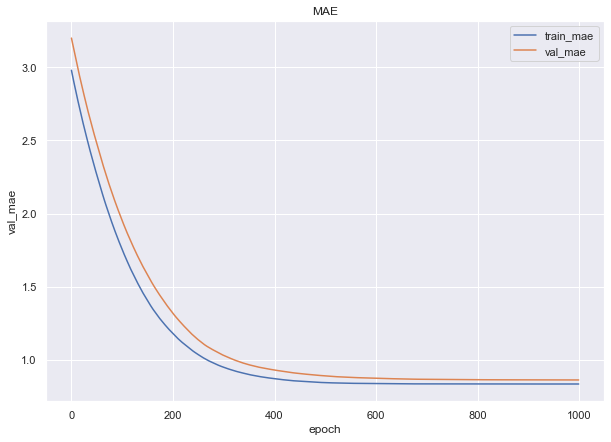

In [17]:
fig, ax = plt.subplots()

sns.lineplot(x='epoch', y='mae', data=hist_df, ax=ax, label='train_mae')
sns.lineplot(x='epoch', y='val_mae', data=hist_df, ax=ax, label='val_mae')

ax.set(title='MAE');

Let us get the model parameters:

In [18]:
[x.numpy() for x in model.weights]

[array([[2.9669125]], dtype=float32), array([1.0224452], dtype=float32)]

We see these values are quite close to the real parameters $\beta_0$ and $\beta_1$.

Finally, let us pred predicted vs test values:

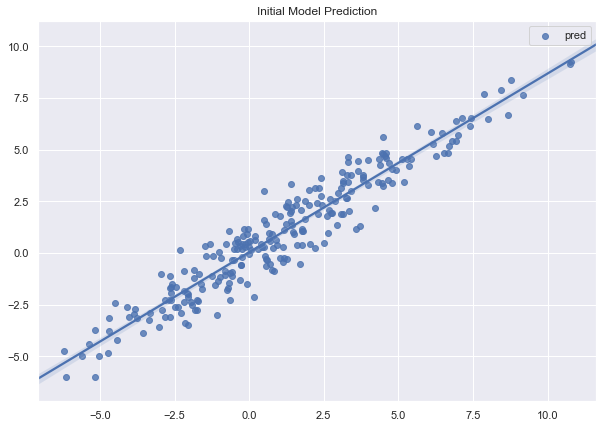

In [19]:
fig, ax = plt.subplots()

# Get prediction.
y_pred = model.predict(X_test)

sns.regplot(
    x=y_test.numpy().flatten(), 
    y=y_pred.flatten(), 
    ax=ax, 
    label='pred'
)

ax.set(title='Initial Model Prediction')
ax.legend();